In [1]:
import warnings
warnings.filterwarnings('ignore')
from pyspark.sql import SQLContext
from pyspark import SparkContext
from pyspark.sql.functions import *
import pyspark.sql.functions as f
from pyspark.sql.types import TimestampType
from datetime import datetime
from pyspark.sql.window import Window
from pyspark.sql.types import IntegerType
from pyspark.ml.regression import RandomForestRegressor,GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
import pandas as pd

VBox()

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
0,application_1591887700321_0001,pyspark,idle,Link,Link,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [3]:
# read data from S3
sqlcontext = SQLContext(sc)
path = 's3://msia431hw3/full_data.csv'
mydata = sqlcontext.read.csv(path, header=True)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [4]:
# change column types from string to integer
df=mydata.select('time_stamp',*(col(c).cast(IntegerType()).alias(c) for c in mydata.columns[1:]))
# extract month and year from time_stamp_column
timestamp_format = 'yyyy-MM-dd'
df=(df
    .withColumn('DateTime',unix_timestamp(col('time_stamp'), timestamp_format).cast('timestamp'))
    .withColumn('Year', year(col('DateTime')))
    .withColumn('Month',month(col('DateTime'))))

###################
# generate features
###################
# Step1: create bar group
#        group 0: 1<=bar<=10; 
#        group 1: 11<=bar<=20;
#        group 2: 21<=bar<=30, etc
# Step2: create features within each bar group
#        the last profit (lag0), lag1 profit, lag2 profit, lag3 profit, lag4 profit, lag5 profit, 
#        average profit, and the standard deviation of profits 
df = df.orderBy(["trade_id", "bar_num"], ascending=[True, True])
df = df.withColumn('barGroup', ((f.col('bar_num') - 1) / 10).cast('integer'))
w = Window().partitionBy('trade_id', 'barGroup').orderBy('barGroup')
df2 = (df
       .select('trade_id','barGroup','bar_num','profit',
           f.last("profit",True).over(w).alias('lag0_profit'),
           f.lag("profit",1).over(w).alias('lag1_profit'),
           f.lag("profit",2).over(w).alias('lag2_profit'),
           f.lag("profit",3).over(w).alias('lag3_profit'),
           f.lag("profit",4).over(w).alias('lag4_profit'),
           f.lag("profit",5).over(w).alias('lag5_profit'),
           f.mean(col('profit')).over(w).alias('mean_profit'),
           f.stddev(col('profit')).over(w).alias('std_profit'))
       .filter(col('bar_num')%10==0)
       .orderBy(["trade_id", "barGroup"], ascending=[True, True]))
# Step 3: add a column for joining features back to the original dataframe
#         bargroup 1 (bar_number 11-20) will use features generated using profits in bargroup 0 (1-10)
#         bargroup 2 (bar_number 21-30) will use features generated using profits in bargourp 1 (11-20)
#         etc.
df2 = (df2
       .withColumn('next_barGroup', f.col('barGroup') + 1)
       .select('trade_id', 'lag0_profit', 'lag1_profit','lag2_profit','lag3_profit','lag4_profit','lag5_profit',
                   'mean_profit', 'std_profit','next_barGroup')
       .withColumnRenamed('trade_id', 't_trade_id'))
# Step 4: join features back to the original data frame
merged_df = df.join(df2, on=(df.barGroup == df2.next_barGroup) & (df.trade_id == df2.t_trade_id), how='left')
# Step 5: keep only data for with bar_num >10; there is nothing to predict for bar 1-10
final_df = merged_df.filter(f.col('bar_num') > 10)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [5]:
def model_trainer(final_df, train_year, train_start_month, train_end_month, test_year ,test_month):
    """
    :param raw_df: original dataframe
    :param train_year: the year of the data used for training
    :param train_start_month: the first month of the data used for training
    :param train_end_month: the last month of the data used for training
    :param test_year: the year of the data used for training
    :param test_month: month of the data used for testing
    :return mape: the MAPE in the test set
    """
    # select features
    target = 'profit'
    features = ['bar_num', 'var12', 'var13', 'var14', 'var15', 'var16', 'var17', 'var18', 'var23', 'var24', 'var25',
                'var26', 'var27', 'var28', 'var34', 'var35', 'var36', 'var37', 'var38', 'var45', 'var46', 'var47',
                'var48', 'var56', 'var57', 'var58', 'var67', 'var68', 'var78',
                'lag0_profit', 'lag1_profit','lag2_profit','lag3_profit','lag4_profit','lag5_profit',
                'mean_profit', 'std_profit'
               ]
    # make model pipeline
    assembler = VectorAssembler(inputCols=features, outputCol='features').setHandleInvalid('skip')
    rf = RandomForestRegressor(labelCol="profit", featuresCol="features")
    pipeline = Pipeline(stages=[assembler, rf])
    # train & test split
    train = (final_df
             .filter(f.col('Year') == train_year)
             .filter((f.col('Month') >= train_start_month) & (f.col('Month') <= train_end_month))
             .select('profit', *(c for c in features)))
    test = (final_df
            .filter(f.col('Year') == test_year)
            .filter(f.col('Month') == test_month)
            .select('profit', *(c for c in features)))
    # fit the model pipeline
    model = pipeline.fit(train)
    predictions = model.transform(test)
    predictions2 = predictions.select(f.col("profit").cast("Float"), f.col("prediction"))
    predictions2 = predictions2.withColumn('ape', 
                                           100*(abs((f.col('profit') - f.col('prediction')) / f.col('profit')))
                                          )
    mape_df = predictions2.select(
        f.mean(f.col('ape')).alias('mape')
    ).collect()
    mape = mape_df[0]['mape']
    return mape

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [6]:
# train and evaluate the model in a move-forward way
result = []
for year in range(2008,2015):
    result.append(model_trainer(final_df, year, 1, 6, year,7))
    result.append(model_trainer(final_df, year, 7, 12, year+1, 1))
result.append(model_trainer(final_df, 2015, 1, 6, 2015,7))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [7]:
# format model results
import pandas as pd
d = {'train_year': [y for y in range(2008,2015) for i in range(2)]+[2015], 
     'train_month': ['1-6','7-12']*7+['1-6'],
     'test_year':[2008]+[y for y in range(2009,2016) for i in range(2)],
     'test_month':[7,1]*7+[7],
     'MAPE':result
    }
output = pd.DataFrame(data=d)
output

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

    train_year train_month  test_year  test_month        MAPE
0         2008         1-6       2008           7   91.213214
1         2008        7-12       2009           1   98.175736
2         2009         1-6       2009           7  100.824119
3         2009        7-12       2010           1  100.706145
4         2010         1-6       2010           7   88.559656
5         2010        7-12       2011           1  109.575925
6         2011         1-6       2011           7   96.151673
7         2011        7-12       2012           1   81.414553
8         2012         1-6       2012           7   85.855130
9         2012        7-12       2013           1  101.935518
10        2013         1-6       2013           7   95.270407
11        2013        7-12       2014           1   84.757486
12        2014         1-6       2014           7   63.905213
13        2014        7-12       2015           1  104.782507
14        2015         1-6       2015           7   99.133207

In [8]:
# calculate min/max/avg MAP
d2 = {'AVG_MAPE': [output.MAPE.mean()], 
     'MAX_MAPE': [output.MAPE.max()],
     'MIN_MAPE':[output.MAPE.min()]
    }
output2 = pd.DataFrame(data=d2)
output2

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

    AVG_MAPE    MAX_MAPE   MIN_MAPE
0  93.484033  109.575925  63.905213

In [9]:
# save output file to S3
output.to_csv('s3://msia431hw3/Exercise3.txt', header=True, index=False, sep=',')
output2.to_csv('s3://msia431hw3/Exercise3.txt', header=True, index=False, sep=',',mode='a')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [10]:
# calculate feature importance to verify whether feature engineering helps
features = ['bar_num', 
            'var12', 'var13', 'var14', 'var15', 'var16', 'var17', 'var18', 'var23', 'var24', 'var25',
            'var26', 'var27', 'var28', 'var34', 'var35', 'var36', 'var37', 'var38', 'var45', 'var46', 'var47',
            'var48', 'var56', 'var57', 'var58', 'var67', 'var68', 'var78',
            'lag0_profit', 'lag1_profit','lag2_profit','lag3_profit','lag4_profit','lag5_profit',
            'mean_profit', 'std_profit'
           ]
# make model pipeline
assembler = VectorAssembler(inputCols=features, outputCol='features').setHandleInvalid('skip')
rf = RandomForestRegressor(labelCol="profit", featuresCol="features")
pipeline = Pipeline(stages=[assembler, rf])
# train & test split
train = (final_df
         .filter(f.col('Year') == 2008)
         .filter((f.col('Month') >= 1) & (f.col('Month') <= 6))
         .select('profit', *(c for c in features)))
test = (final_df
        .filter(f.col('Year') == 2008)
        .filter(f.col('Month') == 7)
        .select('profit', *(c for c in features)))
# fit the model pipeline
model = pipeline.fit(train)

def ExtractFeatureImp(featureImp, dataset, featuresCol):
    list_extract = []
    for i in dataset.schema[featuresCol].metadata["ml_attr"]["attrs"]:
        list_extract = list_extract + dataset.schema[featuresCol].metadata["ml_attr"]["attrs"][i]
    varlist = pd.DataFrame(list_extract)
    varlist['score'] = varlist['idx'].apply(lambda x: featureImp[x])
    return(varlist.sort_values('score', ascending = False))

# calculate feature importance
t = model.transform(train)
feature_Imp = ExtractFeatureImp(model.stages[-1].featureImportances, t, "features")
feature_Imp.to_csv('s3://msia431hw3/Feature_Importance.csv')
feature_Imp.head(10)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

    idx         name     score
29   29  lag0_profit  0.336782
30   30  lag1_profit  0.207024
35   35  mean_profit  0.144983
31   31  lag2_profit  0.097248
33   33  lag4_profit  0.080344
32   32  lag3_profit  0.066161
34   34  lag5_profit  0.047213
11   11        var26  0.002399
20   20        var46  0.002190
21   21        var47  0.002146

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

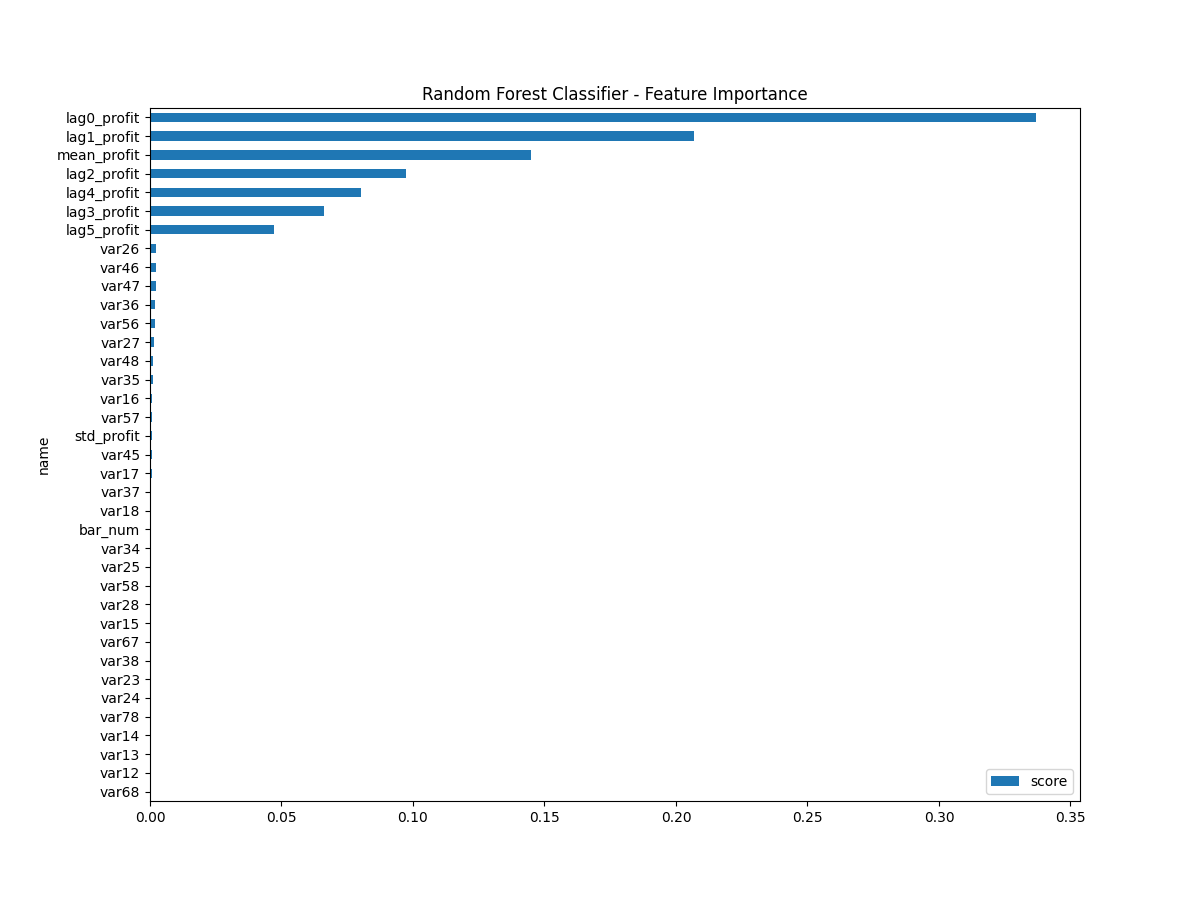

In [26]:
import matplotlib
import matplotlib.pyplot as plt
# feature importance plot
ax = feature_Imp.plot(x='name', y='score', figsize=(12, 9),
                     title="Random Forest Classifier - Feature Importance", kind='barh')
ax.invert_yaxis()
ax.legend(loc='lower right')
plt.show()
%matplot plt